# T2 Strategies

These are based on original Titan strategies with a different parameter structure which makes it easier to use in distributed celery systems.

## Parameters

- strategy: file name of strategy in t2 module
- type: 't2'
- default: parameters used by the base strategy class
- limits: parameters dealing with money management
- custom: parameters used by the specific strategy
- portfolio: set the name key to a string to track different sets of api keys (temporary ad hoc way to accomplish this)

## PortfolioBase class

I am using this as the base class of t2 strategies going forward. It will handle money management (the limits parameters) in the future. It will also have access to other exchanges and other strategies in play for more dynamic money management. I am also semi using this class to non-destructively refactor the BaseStrategy class and possibly replace it altogether.

## Examples

- The first example is a working dual moving average strategy.
- The second example runs all the current working indicators without simulated any trading. The results get stored in the Backtest table. Those are output below.

## Running

Install Docker.

- Run `docker-compose up` to bring up the network with these images
    - jupyter
    - redis
    - timescale
    - all workers
- Go to http://0.0.0.0:8888/lab

In [ ]:
from os import getcwd
from kryptobot.portfolio.manager import Manager

config = getcwd() + '/config.json'
manager = Manager(config=config)

params = {
#     'strategy': 'dema_crossover',
    'strategy': 'dual_simple_moving_average',
    'type': 't2',
    'default': {
        'interval': '5m',
        'exchange': 'cryptopia',
        'base_currency': 'PCN',
        'quote_currency': 'BTC',
        'is_simulated': True,
#         'start': '2017-06-15',
#         'end': '2018-06-15',
    },
    'limits': {
        'capital_base': 1000,
        'order_quantity': 100,
        'position_limit': 1000,
        'profit_target_percentage': 1.2,
        'fixed_stoploss_percentage': .95,
        'trailing_stoploss_percentage': .90
    },
    'custom': {
        'short_window': 3,
        'long_window': 24,
#         'threshold': 0.02
    },
    'portfolio': {
        'name': 'default'
    }
}

manager.run_strategy(params)

In [ ]:
from os import getcwd
from kryptobot.portfolio.manager import Manager

config = getcwd() + '/config.json'
manager = Manager(config=config)

params = {
    'strategy': 'kitchen_sink_analysis',
    'type': 't2',
    'default': {
        'interval': '5m',
        'exchange': 'bittrex',
        'base_currency': 'XMR',
        'quote_currency': 'BTC',
        'is_simulated': True,
    },
    'limits': {
        'capital_base': 1000,
        'order_quantity': 100,
        'position_limit': 1000,
        'profit_target_percentage': 1.2,
        'fixed_stoploss_percentage': .95,
        'trailing_stoploss_percentage': .90
    },
    'custom': {
        'period': 12,
#         Moving Average Envelope
        'env_percentage': 10,
#         2 params for Price Channels
        'upper_percent': 10,
        'lower_percent': 10
    },
    'portfolio': {
        'name': 'default'
    }
}

manager.run_strategy(params)

In [ ]:
from os import getcwd
from kryptobot.portfolio.manager import Manager

config = getcwd() + '/config.json'
manager = Manager(config=config)

results = manager.get_results('e8d2e982-320d-42cc-b086-bae98a0e9e64')
# results.head(200)
results.tail(200)

In [ ]:
import talib
help(talib.APO)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


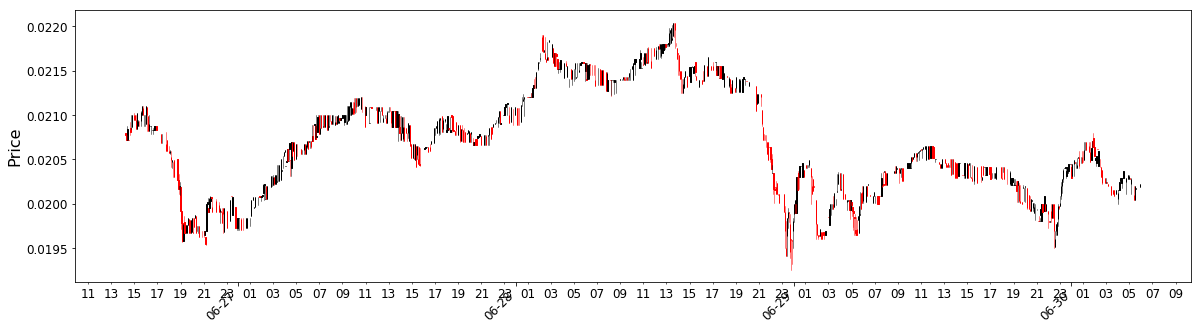

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


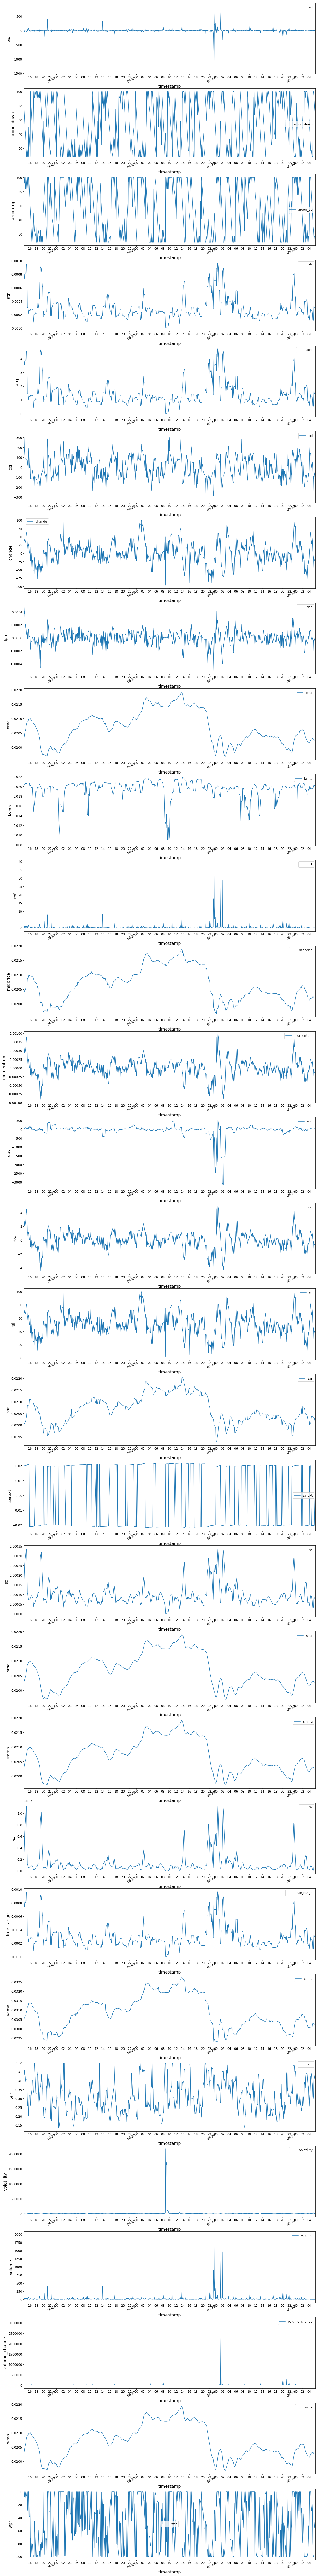

In [79]:
from os import getcwd
from kryptobot.portfolio.manager import Manager
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mdates
import pandas as pd

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

config = getcwd() + '/config.json'
manager = Manager(config=config)
%matplotlib inline

# results = manager.get_candle_chart('e8d2e982-320d-42cc-b086-bae98a0e9e64')

# Candlestick Data

results = manager.get_results('e8d2e982-320d-42cc-b086-bae98a0e9e64')
ohlc_cols = ['timestamp', 'open', 'high', 'low', 'close']
quotes = results[ohlc_cols]
quotes['timestamp'] = pd.to_datetime(quotes['timestamp'])   
quotes.set_index('timestamp',inplace=True)
# quotes.tail(200)

# Candlestick Chart

fig, ax = plt.subplots()
candlestick_ohlc(ax, zip(mdates.date2num(quotes.index.to_pydatetime()),
                         quotes['open'], quotes['high'],
                         quotes['low'], quotes['close']),
                 width=0.001)
ax.xaxis_date()
ax.xaxis.set_major_locator(mdates.DayLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.xaxis.set_minor_locator(mdates.HourLocator(interval=2))
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
ax.set_ylabel('Price')
ax.autoscale_view()
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.gcf().set_size_inches(20, 5)
plt.show()

# Indicator Data

excluded = ['open', 'high', 'low', 'close']
ind_cols = [c for c in results.columns if c not in excluded]
inds = results[ind_cols]
inds['timestamp'] = pd.to_datetime(inds['timestamp'])
nums = inds.select_dtypes(include=['float64', 'int64', 'datetime64'])
nums.set_index('timestamp',inplace=True)

# Indicator Charts

col_count = len(nums.columns)
count = 0
for key in nums:
    count = count + 1
    ax1 = plt.subplot(col_count, 1, count)
    nums[[key]].plot(ax=ax1)
    ax1.set_ylabel(key)
    ax1.xaxis.set_major_locator(mdates.DayLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    ax1.xaxis.set_minor_locator(mdates.HourLocator(interval=2))
    ax1.xaxis.set_minor_formatter(mdates.DateFormatter('%H'))
    
plt.gcf().set_size_inches(20, 200)
plt.show()